# Data Preprocessing

## Import Datasets

In [135]:
import pandas as pd
import os

datasets_folder_path = "./dataset"

features_df = pd.read_csv(os.path.join(datasets_folder_path, 'combined_features.csv'))
features_df = features_df.set_index('participant_id')

labels_df = pd.read_csv(os.path.join(datasets_folder_path, 'turker_scores_full_interview.csv'))
labels_df = labels_df.set_index('Participant')
labels_df = labels_df.loc[labels_df['Worker'] == 'AGGR']

features_df.index = features_df.index.str.lower()
labels_df.index = labels_df.index.str.lower()
combined_df = features_df.join(labels_df[['RecommendHiring']], how='left')

## Fill NaN Values

In [136]:
print(combined_df.isna().sum().sum())
combined_df.fillna(combined_df.mean(), inplace=True)
print(combined_df.isna().sum().sum())

16
0


## Drop Unnecessary Columns

In [137]:
dropped_lexical_columns = ['Swear', 'Numbers', 'Inhibition', 'Preceptual','Anxiety', 'Anger', 'Sadness', 'Work', 'Articles',]
dropped_facial_columns = [
'average_inner_brow_height_max' , 'average_inner_brow_height_median', 'average_inner_brow_height_min',
'average_outer_brow_height_max', 	'average_outer_brow_height_median', 	'average_outer_brow_height_min',
'eye_open_max', 'eye_open_median', 'eye_open_min',
'inner_lip_height_max', 'inner_lip_height_median', 'inner_lip_height_min',
'lip_corner_distance_max', 'lip_corner_distance_median', 'lip_corner_distance_min',
'outer_lip_height_max', 'outer_lip_height_median', 'outer_lip_height_min',
'smile_max', 'smile_median', 'smile_min',
'pitch_max', 'pitch_median', 'pitch_min',
'roll_max', 'roll_median', 'roll_min',
'yaw_max', 'yaw_median', 'yaw_min'
                           ]

combined_df = combined_df.drop(columns=dropped_facial_columns + dropped_lexical_columns)
# combined_df = combined_df.reset_index(drop=True)

In [138]:
combined_df.columns

Index(['f0_mean', 'f0_min', 'f0_max', 'f0_range', 'f0_sd', 'intensity_mean',
       'intensity_min', 'intensity_max', 'intensity_range', 'intensity_sd',
       'f1_mean', 'f1_sd', 'f2_mean', 'f2_sd', 'f3_mean', 'f3_sd',
       'f2_f1_mean', 'f3_f1_mean', 'f2_f1_sd', 'f3_f1_sd', 'jitter', 'shimmer',
       'percent_unvoiced', 'percent_breaks', 'pause_duration_max',
       'pause_duration_avg', 'duration', 'average_outer_brow_height_mean',
       'average_inner_brow_height_mean', 'eye_open_mean',
       'outer_lip_height_mean', 'inner_lip_height_mean',
       'lip_corner_distance_mean', 'smile_mean', 'pitch_mean', 'yaw_mean',
       'roll_mean', 'average_outer_brow_height_std',
       'average_inner_brow_height_std', 'eye_open_std', 'outer_lip_height_std',
       'inner_lip_height_std', 'lip_corner_distance_std', 'smile_std',
       'pitch_std', 'yaw_std', 'roll_std', 'Total Words', 'Unique Words',
       'Filler Words', 'Audio Duration (s)', 'Duration/Total Words',
       'Duration/Uniq

# Split Data

In [139]:
X = combined_df.iloc[:, 1:-1].values
y = combined_df.iloc[:, -1].values

In [140]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

groups = combined_df.index.str.extract(r"[Pp]{1,2}(\d+)")[0]
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train_indices, test_indices in gss.split(combined_df, combined_df["RecommendHiring"], groups):
    train_df = combined_df.iloc[train_indices]
    test_df = combined_df.iloc[test_indices]

X_train, y_train = train_df.drop(columns=["RecommendHiring"]), train_df["RecommendHiring"]
X_test, y_test = test_df.drop(columns=["RecommendHiring"]), test_df["RecommendHiring"]

# Feature Scaling

In [141]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # fit_transofmr expects a 2D array, so we need to reshape to 2D from 1D.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Train SVR Model

In [ ]:
from sklearn.svm import SVR
import numpy as np

svr_regressor = SVR(kernel='rbf')
# svr_regressor.fit(X_train_scaled, y_train_scaled)
svr_regressor.fit(X_train_scaled, y_train.values.flatten()) # -1 tells NumPy to automatically determine the number of rows based on the existing number of elements.

SVR()

# Prediction

In [ ]:
# y_pred_scaled = svr_regressor.predict(X_test_scaled)
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_pred = svr_regressor.predict(X_test_scaled)

# Model Evaluation Metrics

In [144]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Training scores
train_pred = scaler_y.inverse_transform(
    svr_regressor.predict(X_train_scaled).reshape(-1, 1)
)
train_r2 = r2_score(y_train, train_pred)

print(
    f"""
=== Model Performance ===
Test Scores:
- MSE: {mse:.3f}
- MAE: {mae:.3f}
- R²: {r2:.3f}
"""
)


=== Model Performance ===
Test Scores:
- MSE: 0.458
- MAE: 0.569
- R²: 0.033



# Visualization

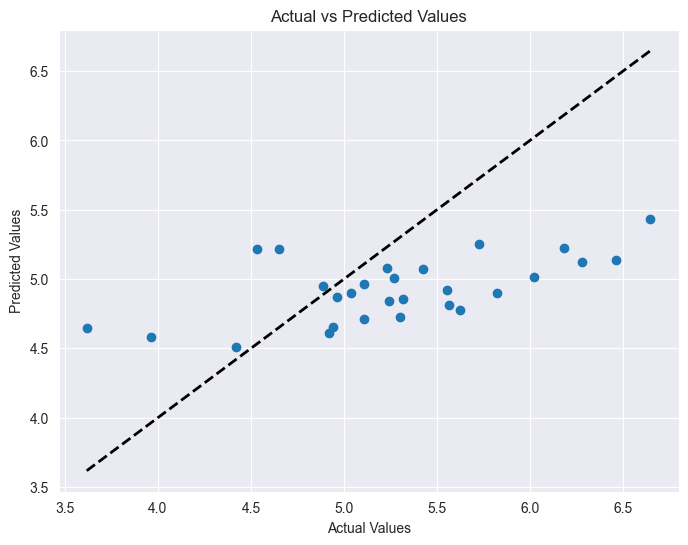

In [145]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)    # "k" stands for black (k is the color code for black in Matplotlib). # "--" makes it a dashed line. # lw stands for line width.
	

# Labels and title
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")
ax.set_title("Actual vs Predicted Values")
ax.grid(True)

plt.show()